# Cleaning and Exploring Food Safety Data 

<img src="scoreCard.jpg" width=400>

In this notebook, we will investigate restaurant food safety scores for restaurants in San Francisco. Above is a sample score card for a restaurant. The scores and violation data have been made available by the San Francisco Department of Public Health. The main goal for our analysis would be to better understand how restaurants are scored.

In [59]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

## Downloading the data

In [60]:
import utils
source_data_url = 'http://www.ds100.org/fa18/assets/datasets/hw2-SFBusinesses.zip'
target_file_name = 'data.zip'
data_dir = '.'

dest_path = utils.fetch_and_cache(data_url=source_data_url, data_dir=data_dir, file=target_file_name, force=False)

Using cached version that was downloaded (UTC): Tue Sep  4 18:05:07 2018


### Looking Inside and Extracting the Zip Files

In [61]:
my_zip = zipfile.ZipFile(dest_path, 'r')
list_names = [f.filename for f in my_zip.filelist]

In [62]:
[(name, my_zip.getinfo(name).file_size) for name in list_names]

[('violations.csv', 3726206),
 ('businesses.csv', 660231),
 ('inspections.csv', 466106),
 ('legend.csv', 120)]

In [63]:
for f in [(name, my_zip.getinfo(name).file_size) for name in list_names]:
    print(f[0], f[1])

violations.csv 3726206
businesses.csv 660231
inspections.csv 466106
legend.csv 120


In [64]:
from pathlib import Path
data_dir = Path('data')
my_zip.extractall(data_dir)

The above code should have created a folder called "data", and in it should be the four CSV files corresponding to violations, businesses, inspections and legend.

### Looking Inside the Files

Let's print out the first 5 lines of all four files that we just extracted from the zipfile.

In [65]:
list_names

['violations.csv', 'businesses.csv', 'inspections.csv', 'legend.csv']

In [66]:
ds100_utils.head('data/legend.csv', 5)

['"Minimum_Score","Maximum_Score","Description"\n',
 '0,70,"Poor"\n',
 '71,85,"Needs Improvement"\n',
 '86,90,"Adequate"\n',
 '91,100,"Good"\n']

In [67]:
for name in list_names:
    print(ds100_utils.head('data/' + name, 5))

['"business_id","date","description"\n', '19,"20171211","Inadequate food safety knowledge or lack of certified food safety manager"\n', '19,"20171211","Unapproved or unmaintained equipment or utensils"\n', '19,"20160513","Unapproved or unmaintained equipment or utensils  [ date violation corrected: 12/11/2017 ]"\n', '19,"20160513","Unclean or degraded floors walls or ceilings  [ date violation corrected: 12/11/2017 ]"\n']
['"business_id","name","address","city","state","postal_code","latitude","longitude","phone_number"\n', '19,"NRGIZE LIFESTYLE CAFE","1200 VAN NESS AVE, 3RD FLOOR","San Francisco","CA","94109","37.786848","-122.421547","+14157763262"\n', '24,"OMNI S.F. HOTEL - 2ND FLOOR PANTRY","500 CALIFORNIA ST, 2ND  FLOOR","San Francisco","CA","94104","37.792888","-122.403135","+14156779494"\n', '31,"NORMAN\'S ICE CREAM AND FREEZES","2801 LEAVENWORTH ST ","San Francisco","CA","94133","37.807155","-122.419004",""\n', '45,"CHARLIE\'S DELI CAFE","3202 FOLSOM ST ","San Francisco","CA","

### Reading in the Files

Based on the above information, we will load `businesses.csv`, `inspections.csv`, and `violations.csv` into pandas data frames with the following names: `bus`, `ins`, and `vio` respectively.

Because of character encoding issues one of the files (`bus`) will require an additional argument `encoding='ISO-8859-1'` when calling `pd.read_csv`. 

In [68]:
dsDir = Path('data')
dsDir/'violations.csv'

PosixPath('data/violations.csv')

In [69]:
# path to directory containing data
dsDir = Path('data')

bus = pd.read_csv(dsDir/'businesses.csv', encoding='ISO-8859-1')
ins = pd.read_csv(dsDir/'inspections.csv')
vio = pd.read_csv(dsDir/'violations.csv')

Now that you've read in the files, let's see the top few lines of the `bus`, `ins`, and `vio` dataframes.

In [70]:
bus.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440


In [71]:
ins.head()

,business_id,score,date,type
0,19,94,20160513,routine
1,19,94,20171211,routine
2,24,98,20171101,routine
3,24,98,20161005,routine
4,24,96,20160311,routine


In [72]:
vio.head()

,business_id,date,description
0,19,20171211,Inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...
3,19,20160513,Unclean or degraded floors walls or ceilings ...
4,19,20160513,Food safety certificate or food handler card n...


From looking at just the first few records in all three datasets we can already make the following observations:
* In the bus dataset we see that some records in phone_number field are missing and also the phone number has the country code including the plus sign which might be problematic for analysis later.
* In ins and vio datasets we see that records in date field are not delimited and instead are continuous numbersm

Let's also compute summaries of various statistics of all 3 of our dataframes.

In [73]:
bus.describe()

,business_id,latitude,longitude
count,6406.000000,3270.000000,3270.000000
mean,53058.248049,37.773662,-122.425791
std,34928.238762,0.022910,0.027762
min,19.000000,37.668824,-122.510896
25%,7405.500000,37.760487,-122.436844
50%,68294.500000,37.780435,-122.418855
75%,83446.500000,37.789951,-122.406609
max,94574.000000,37.824494,-122.368257


In [74]:
ins.describe()

,business_id,score,date
count,14222.000000,14222.000000,1.422200e+04
mean,45138.752637,90.697370,2.016242e+07
std,34497.913056,8.088705,8.082778e+03
min,19.000000,48.000000,2.015013e+07
25%,5634.000000,86.000000,2.016021e+07
50%,61462.000000,92.000000,2.016091e+07
75%,78074.000000,96.000000,2.017061e+07
max,94231.000000,100.000000,2.018012e+07


In [75]:
vio.describe()

,business_id,date
count,39042.000000,3.904200e+04
mean,45674.440244,2.016283e+07
std,34172.433276,7.874679e+03
min,19.000000,2.015013e+07
25%,4959.000000,2.016031e+07
50%,62060.000000,2.016092e+07
75%,77681.000000,2.017063e+07
max,94231.000000,2.018012e+07


Now we will explore each file in turn, including determining its granularity and primary keys and exploring many of the variables indivdually. Let's begin with the businesses file, which has been read into the `bus` dataframe.

## Examining the Business data

From its name alone, we expect the `businesses.csv` file to contain information about the restaurants. Let's investigate the granularity of this dataset.

Let's check if the `business_id` is unique for each record?

In [76]:
is_business_id_unique = bus['business_id'].value_counts().sum() == len(bus)

Let's find the number of records, examine what what each record represents (e.g., a store, a chain, a transaction), and see what the primary key is:

In [77]:
print(len(bus['business_id'].unique()))

6406


In [78]:
bus.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440


There are 6406 records and each record represents information about a food establishment like name, address, location and phone number. The primary key is business_id.

Next, let's  explore some of the variables in the business table. We begin by examining the zip code column.

In [79]:
type(bus.iloc[0, -4])

str

In [80]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6406 entries, 0 to 6405
Data columns (total 9 columns):
business_id     6406 non-null int64
name            6406 non-null object
address         6406 non-null object
city            6406 non-null object
state           6406 non-null object
postal_code     6166 non-null object
latitude        3270 non-null float64
longitude       3270 non-null float64
phone_number    5766 non-null object
dtypes: float64(2), int64(1), object(6)
memory usage: 450.5+ KB


We see that zip codes are qualitiative and nominal feature. They seem to be enocoded as object type, more specifically as strings.


To explore the zip code values, it makes sense to examine counts, i.e., the number of records  that have the same zip code value. This is essentially answering the question: How many restaurants are in each zip code? 

In [81]:
bus['name'].groupby(bus['postal_code']).size().sort_values(ascending = False)

postal_code
94110        596
94103        552
94102        462
94107        460
94133        426
94109        380
94111        277
94122        273
94118        249
94115        243
94105        232
94108        228
94114        223
94117        204
94112        195
94124        191
94123        173
94121        160
94104        139
94132        133
94116         99
94134         77
94127         71
94131         49
94158         32
94130          7
94143          5
94188          4
94101          2
94014          2
94013          2
00000          2
CA             2
94129          2
941102019      1
94120          1
941033148      1
94544          1
94545          1
94602          1
941            1
94080          1
94066          1
94621          1
95105          1
92672          1
64110          1
Ca             1
Name: name, dtype: int64

Here we need to make sure we take into account businesses with missing zip codes. 

To include null postal codes in the zip_counts series above we can use `fillna`, which will replace all null (a.k.a. NaN) values with a string of our choosing like "?????".

In [82]:
zip_counts = bus.fillna("?????").groupby("postal_code").size().sort_values(ascending=False)
zip_counts.head(15)

postal_code
94110    596
94103    552
94102    462
94107    460
94133    426
94109    380
94111    277
94122    273
94118    249
94115    243
?????    240
94105    232
94108    228
94114    223
94117    204
dtype: int64

Missing zip codes aren't our only problem. There is also some bad data where the postal code got messed up, e.g., there are 3 'Ca' and 3 'CA' values. Additionally, there are some extended postal codes that are 9 digits long, rather than the typical 5 digits.

Let's clean up the extended zip codes by dropping the digits beyond the first 5. Rather than deleting replacing the old values in the `postal_code` columnm, we'll instead create a new column called `postal_code_5`.

The reason we're making a new column is because it's typically good practice to keep the original values when we are manipulating data. This makes it easier to recover from mistakes, and also makes it more clear that we are not working with the original raw data.

In [83]:
bus['postal_code_5'] = bus['postal_code'].str[:5]
bus.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
0,19,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR",San Francisco,CA,94109,37.786848,-122.421547,+14157763262,94109
1,24,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR",San Francisco,CA,94104,37.792888,-122.403135,+14156779494,94104
2,31,NORMAN'S ICE CREAM AND FREEZES,2801 LEAVENWORTH ST,San Francisco,CA,94133,37.807155,-122.419004,NaN,94133
3,45,CHARLIE'S DELI CAFE,3202 FOLSOM ST,San Francisco,CA,94110,37.747114,-122.413641,+14156415051,94110
4,48,ART'S CAFE,747 IRVING ST,San Francisco,CA,94122,37.764013,-122.465749,+14156657440,94122


### A Closer Look at Missing Zip Codes

Let's look more closely at businesses with missing zip codes.

In [84]:
bus.loc[bus['postal_code_5'].isnull(), :]

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
1702,8202,XIAO LOONG,250 WEST PORTAL AVENUE,San Francisco,CA,NaN,37.738616,-122.468775,+14152792647,NaN
1725,9358,EDGEWOOD CHILDREN'S CENTER,1801 VICENTE ST,San Francisco,CA,NaN,37.739083,-122.485437,NaN,NaN
1731,9582,DIMPLES,1700 POST ST.,San Francisco,CA,NaN,37.785632,-122.429794,+14155190341,NaN
1747,10011,OSHA THAI NOODLE,819 VALENCIA ST.,San Francisco,CA,NaN,37.759943,-122.421332,+14153109293,NaN
1754,10227,THE NAPPER TANDY,3200 24TH ST,San Francisco,CA,NaN,37.752581,-122.416482,+14155507510,NaN
1762,10372,BERNAL HEIGHTS NEIGBORHOOD CENTER,515 CORTLAND AVE,San Francisco,CA,NaN,37.739110,-122.416404,+14152062142,NaN
1763,10373,EL TONAYENSE #1,1717 HARRISON ST,San Francisco,CA,NaN,37.769426,-122.413446,+14155596127,NaN
1764,10376,GOOD FRIKIN CHICKEN,10 29TH ST,San Francisco,CA,NaN,37.744369,-122.420967,+14158601365,NaN
1766,10406,SUNSET YOUTH SERVICES,3918 JUDAH ST,San Francisco,CA,NaN,37.760560,-122.504027,NaN,NaN
1778,10964,ANGEL'S HOT DOGS,CORNER OF ALAMEDA AND HENRY ADAMS,San Francisco,CA,NaN,NaN,NaN,NaN,NaN


We see that many of the records having missing postal code values seem to represent establishments that don't have a fixed address like catering and vending establishments, hot dog stands and food trucks.

### Incorrect Zip Codes

This dataset is supposed to be only about San Francisco so let us make sure that all zip codes are in SF. We will set up a list of all San Francisco zip codes.

In [85]:
all_sf_zip_codes = ["94102", "94103", "94104", "94105", "94107", "94108", "94109", "94110", "94111", "94112", "94114", "94115", "94116", "94117", "94118", "94119", "94120", "94121", "94122", "94123", "94124", "94125", "94126", "94127", "94128", "94129", "94130", "94131", "94132", "94133", "94134", "94137", "94139", "94140", "94141", "94142", "94143", "94144", "94145", "94146", "94147", "94151", "94158", "94159", "94160", "94161", "94163", "94164", "94172", "94177", "94188"]

In [86]:
notSF_zip_code_businesses = bus[(bus["postal_code_5"].notnull()) & (~bus["postal_code_5"].isin(all_sf_zip_codes))]

In [87]:
notSF_zip_code_businesses

,business_id,name,address,city,state,postal_code,latitude,longitude,phone_number,postal_code_5
1211,5208,GOLDEN GATE YACHT CLUB,1 YACHT RD,San Francisco,CA,941,37.807878,-122.442499,+14153462628,941
1372,5755,J & J VENDING,VARIOUS LOACATIONS (17),San Francisco,CA,94545,NaN,NaN,+14156750910,94545
1373,5757,"RICO VENDING, INC",VARIOUS LOCATIONS,San Francisco,CA,94066,NaN,NaN,+14155836723,94066
2258,36547,EPIC ROASTHOUSE,PIER 26 EMBARARCADERO,San Francisco,CA,95105,37.788962,-122.387941,+14153699955,95105
2293,37167,INTERCONTINENTAL SAN FRANCISCO EMPLOYEE CAFETERIA,888 HOWARD ST 2ND FLOOR,San Francisco,CA,94013,37.781664,-122.404778,+14156166532,94013
2295,37169,INTERCONTINENTAL SAN FRANCISCO 4TH FL. KITCHEN,888 HOWARD ST 4TH FLOOR,San Francisco,CA,94013,37.781664,-122.404778,+14156166532,94013
2846,64540,LEO'S HOT DOGS,2301 MISSION ST,San Francisco,CA,CA,37.760054,-122.419166,+14152406434,CA
2852,64660,HAIGHT STREET MARKET,1530 HAIGHT ST,San Francisco,CA,92672,37.769957,-122.447533,+14152550643,92672
2857,64738,JAPACURRY,PUBLIC,San Francisco,CA,CA,37.777122,-122.419639,+14152444785,CA
2969,65856,BAMBOO ASIA,41 MONTGOMERY ST,San Francisco,CA,94101,37.774998,-122.418299,+14156246790,94101


At this point we might indivdually look up every one of these strange records. But for the purposes of this notebook let's focus on just two of them: zip codes 94545 and 94602. Using Google we can identify what cities these zip codes appear in. For the one with zip code 94602, we will try searching for the business name and locate its real address.

94545 - This postal code is in Hayward, CA. The address field corresponding to this postal code lists the address for the establishment
as various locations so it might be that there is a location/branch in Hayward and somehow the postal code for that location
ended up in this dataset.

94609 - This postal code is in Oakland. Googling Orbit Room reveals that its address as listed in the dataset is correct. But there was an Earth Orbit Room in 
Oakland and it's possible that this Orbit Room got mixed up with the one in Oakland.

Let's correct 94602 to the more likely value based on our analysis. 

In [88]:
bus['postal_code_5'] = bus['postal_code_5'].str.replace("94602", "94102")

## 4: Latitude and Longitude

Let's also consider latitude and longitude values and get a sense of how many are missing.

In [89]:
missing_latlongs = bus['longitude'].isnull().sum()
missing_latlongs

3136

Let's try to identify which zip codes are missing the most longitude values.

Let's focus on only the "dense" zip codes of the city of San Francisco, listed below as `sf_dense_zip`.

In [90]:
sf_dense_zip = ["94102", "94103", "94104", "94105", "94107", "94108",
            "94109", "94110", "94111", "94112", "94114", "94115",
            "94116", "94117", "94118", "94121", "94122", "94123", 
            "94124", "94127", "94131", "94132", "94133", "94134"]

In [91]:
bus_sf = bus[bus["postal_code_5"].isin(sf_dense_zip)]
def compute_null(series):
    return series.isnull().sum()
    
num_missing_in_each_zip = bus['longitude'].groupby(bus['postal_code_5']).agg(compute_null).sort_values(ascending = False)
num_missing_in_each_zip

postal_code_5
94110    294.0
94103    285.0
94107    275.0
94102    222.0
94109    171.0
94133    159.0
94122    132.0
94111    129.0
94105    127.0
94124    118.0
94118    117.0
94114    111.0
94108     98.0
94115     95.0
94117     86.0
94104     79.0
94112     77.0
94132     71.0
94123     68.0
94121     60.0
94116     42.0
94134     36.0
94158     30.0
94127     30.0
94131     16.0
94130      5.0
94188      4.0
94143      3.0
94129      2.0
94014      2.0
94101      1.0
94080      1.0
94066      1.0
64110      1.0
Ca         1.0
94544      1.0
94545      1.0
94621      1.0
00000      1.0
CA         0.0
94120      0.0
941        0.0
94013      0.0
92672      0.0
95105      0.0
Name: longitude, dtype: float64

So we just counted the number of null values per zip code more helpful would be the count the proportion of null values in each zip.

In [92]:
def compute_not_null(series):
    return series.notnull().sum()
null_count = bus_sf['longitude'].groupby(bus_sf['postal_code_5']).agg(compute_null).sort_values(ascending = False)
not_null_count = bus_sf['longitude'].groupby(bus_sf['postal_code_5']).agg(compute_not_null).sort_values(ascending = False)
fraction_null = null_count/(not_null_count + null_count)
null_count = null_count.rename('null count')
not_null_count = not_null_count.rename('not null count')
fraction_null = fraction_null.rename('fraction null')

fraction_missing_df = pd.concat([null_count, not_null_count, fraction_null], axis = 1)
fraction_missing_df = fraction_missing_df.sort_values(by = ['fraction null'], ascending = False)
fraction_missing_df

/home/kshitiz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,null count,not null count,fraction null
94124,118.0,73.0,0.617801
94107,275.0,185.0,0.597826
94104,79.0,60.0,0.568345
94105,127.0,105.0,0.547414
94132,71.0,62.0,0.533835
94103,285.0,268.0,0.515371
94114,111.0,112.0,0.497758
94110,294.0,303.0,0.492462
94122,132.0,141.0,0.483516
94102,222.0,241.0,0.479482


## Summary of the Business Data

Before we move on to explore the other data, let's take stock of what we have learned and the implications of our findings on future analysis. 

* We found that the business id is unique across records and so we may be able to use it as a key in joining tables. 
* We found that there are many errors with the zip codes. As a result, we may want to drop the records with zip codes outside of San Francisco or to treat them differently. For some of the bad values, we could take the time to look up the restaurant address online and fix these errors.   
* We found that there are a huge number of missing longitude (and latitude) values. Fixing would require a lot of work, but could in principle be automated for business with well formed addresses. 

## Investigate the Inspection Data

Let's now turn to the inspection DataFrame. Earlier, we found that the inspection dataframe has 4 columns named `business_id`, `score`, `date` and `type`. Now let's determine the granularity of the dataset and investigate the kinds of information provided for the inspections. 

Let's start by looking again at the first 5 rows of `ins` to see what we're working with.

In [93]:
ins.head(5)

,business_id,score,date,type
0,19,94,20160513,routine
1,19,94,20171211,routine
2,24,98,20171101,routine
3,24,98,20161005,routine
4,24,96,20160311,routine


From calling `head`, we know that each row in this table corresponds to the inspection of a single business. Let's get a sense of the total number of inspections conducted, as well as the total number of unique businesses that occur in the dataset.

In [94]:
rows_in_table = ins.shape[0]
unique_ins_ids = len(ins['business_id'].unique())

So we have an average of roughly 3 inspections per business.

Next, we examine the Series in the `ins` dataframe called `type`. From examining the first few rows of `ins`, we see that `type` is a string and one of its values is 'routine', presumably for a routine inspection. What values does `type` take on? How many occurrences of each value is in the DataFrame? What are the implications for further analysis?

In [95]:
print(ins['type'].unique())
ins['type'].value_counts()

['routine' 'complaint']


routine      14221
complaint        1
Name: type, dtype: int64

We see that there are two types of inspections: routine and complaint. With the exception of one inspection which was
plausibly done to follow up on a complaint, all the inspections are of routine type. We could look into which restaurant
was inspected for a complaint. More importantly, this tells us we can't really analyze this data from the perspective of type 
of inspection because almost all of them were just routine.

Moving on we're going to try to figure out what years the data spans. Unfortunately, the dates in our file are formatted as strings such as `20160503`, which are a little tricky to interpret. The ideal solution for this problem is to modify our dates so that they are in an appropriate format for analysis. 

In the cells below we will add a new column to `ins` called `new_date` which contains the `date` stored as a datetime object as well as a year column.

In [96]:
ins['new_date'] = pd.to_datetime(ins['date'], format='%Y%m%d')
ins['year'] = ins['new_date'].dt.year
ins.head(5)

,business_id,score,date,type,new_date,year
0,19,94,20160513,routine,2016-05-13,2016
1,19,94,20171211,routine,2017-12-11,2017
2,24,98,20171101,routine,2017-11-01,2017
3,24,98,20161005,routine,2016-10-05,2016
4,24,96,20160311,routine,2016-03-11,2016


Now that we have this handy `year` column, we can try to understand our data better.

What range of years is covered in this data set? Are there roughly the same number of inspections each year?

In [97]:
ins['year'].value_counts()

2016    5443
2017    5166
2015    3305
2018     308
Name: year, dtype: int64

We see that the tange of years is from 2015 to 2018. There were roughly same number of inspections in 2016 and 2017 but the number of inspections
were considerably less in 2015 and even lesser in 2018. So no there aren't roughly same number of inspections each year.

## Explore inspection score

Let's look at the distribution of scores. As we saw before when we called head on this data, inspection scores appear to be integer values. The discreteness of this variable means that we can use a barplot to visualize the distribution of the inspection score.

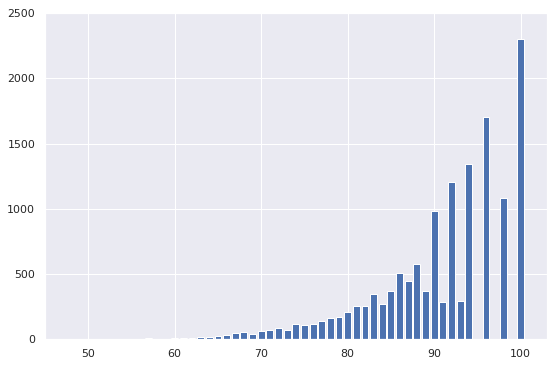

In [98]:
scoreCts = ins['score'].value_counts()
plt.figure(figsize = (9,6))
plt.bar(x = scoreCts.index, height = scoreCts.values)
plt.ylim(0, 2500)
plt.show()

Based on the plot the distribution is left skewed and seems to be unimodal.
The score values are not continuous and some of them are missing.
For e.g. no restaurant seems to have been awarded a score of 93, 95, 97, 98 or 99.
Most restaurants seem to have scored above 90 i.e in the "good" range.

Let's figure out which restaurants had the worst scores ever. To that end we will create a new dataframe called `ins_named`. It will be exactly the same as `ins`, except that it will have the name and address of every business, as determined by the `bus` dataframe. If a `business_id` in `ins` does not exist in `bus`, the name and address will be given as NaN.

In [99]:
ins_named = pd.merge(left = ins, right = bus[['business_id', 'name', 'address']], how = 'left', on = 'business_id')
ins_named.head()

,business_id,score,date,type,new_date,year,name,address
0,19,94,20160513,routine,2016-05-13,2016,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR"
1,19,94,20171211,routine,2017-12-11,2017,NRGIZE LIFESTYLE CAFE,"1200 VAN NESS AVE, 3RD FLOOR"
2,24,98,20171101,routine,2017-11-01,2017,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR"
3,24,98,20161005,routine,2016-10-05,2016,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR"
4,24,96,20160311,routine,2016-03-11,2016,OMNI S.F. HOTEL - 2ND FLOOR PANTRY,"500 CALIFORNIA ST, 2ND FLOOR"


Using this data frame, we can identify the restaurant with the lowest inspection scores ever. 

In [100]:
ins_named.loc[ins_named['score'] == min(ins_named['score']), 'name']

13179    DA CAFE
Name: name, dtype: object

From DA Cafe's Yelp page it seems like it's a cheap and inexpensive restaurant. 
Many reviews praise the restaurant's food on the first page but there is one 1 star
review mentioning how there was a baby cockroach
in one of the dishes. The restaurant doesn't seem hygienic and I think that's
why it received the lowest inspection score.

## Restaurant Ratings Over Time

Let's see which restaurant has had the most extreme change in their ratings. To that end we define the "swing" of a restaurant as the difference between its lowest and highest ever rating. If a restaurant has been reviewed fewer than two times, we will say its swing is zero.

In [101]:
df = pd.concat(g for _, g in ins_named.groupby("business_id") if len(g) > 1)
def swing(series):
    return max(series) - min(series)
swing_df = df.groupby("business_id").aggregate({'score' : [swing]})
sorted_swing_df = swing_df.sort_values(by = [('score', 'swing')], ascending = False).head()

In [102]:
# get the business ids
bus_ids = sorted_swing_df.index[:3]
# index these ids
max_swing_res = ins_named.loc[ins_named['business_id'].isin(bus_ids), 'name'].unique()
max_swing_res

array(["JOANIE'S DINER INC.", 'NEW GARDEN RESTAURANT, INC.', 'THE CREW'],
      dtype=object)

So JOANIE'S DINER INC., NEW GARDEN RESTAURANT, INC., THE CREW

In [103]:
To get a sense of the number of times each restaurant has been inspected, create a multi-indexed dataframe called `inspections_by_id_and_year` where each row corresponds to data about a given business in a single year, and there is a single data column named `count` that represents the number of inspections for that business in that year. 

SyntaxError: invalid syntax (<ipython-input-103-2cbf1bec6ec4>, line 1)

In [ ]:
df = ins_named.groupby(['business_id', 'year']).size().to_frame()
inspections_by_id_and_year = df.rename(columns = {0 : "count"})
inspections_by_id_and_year.head(10)

We see that some businesses are inspected many times in a single year. Let's get a sense of the distribution of the counts of the number of inspections by calling `value_counts`. There are quite a lot of businesses with 2 inspections in the same year, so it seems like it might be interesting to see what we can learn from such businesses.

In [ ]:
inspections_by_id_and_year['count'].value_counts()

What's the relationship between the first and second scores for the businesses with 2 inspections in a year? Do they typically improve? For simplicity, let's focus on only 2016.

First, we will make a dataframe called `scores_pairs_by_business` indexed by `business_id` (containing only businesses with exactly 2 inspections in 2016).  This dataframe contains the field `score_pair` consisting of the score pairs ordered chronologically  `[first_score, second_score]`. 

In [ ]:
ins.groupby('business_id').filter(lambda subframe : len(subframe)

In [ ]:
def collect_scores(series):
    return ([series.iloc[0],  series.iloc[1]])
ins2016 = ins[ins['year'] == 2016]
insTwo2016 = pd.concat(g for _, g in ins2016.groupby("business_id") if len(g) == 2).sort_values(by = ['date'])
scores_pairs_by_business = insTwo2016.groupby('business_id').aggregate({'score' : [collect_scores]})
scores_pairs_by_business.rename(index = str, columns = {'collect_scores' : 'score_pair'}, inplace = True)
scores_pairs_by_business.columns = scores_pairs_by_business.columns.droplevel(0)

In [ ]:
first_score = [point[0] for point in scores_pairs_by_business.score_pair.values]
second_score = [point[1] for point in scores_pairs_by_business.score_pair.values]

In [ ]:
plt.scatter(first_score, second_score, facecolors = 'none', edgecolors='blue')
t = np.linspace(54, 100, 100)
plt.plot(t, t, '-r')
plt.xlim(55, 100)
plt.ylim(55, 100)
plt.ylabel("second score")
plt.xlabel("first score")
plt.show()

Another way to compare the scores from the two inspections is to examine the difference in scores. We can obtain that by subtracting the first score from the second in `scores_pairs_by_business`. Then we can make a histogram of these differences in the scores to visualize them. We might expect these differences to be positive, indicating an improvement from the first to the second inspection.

In [ ]:
plt.figure(figsize = (7, 4))
plt.hist(np.array(second_score) - np.array(first_score), bins = 30)
plt.show()

If we assume restaurant's score improves from the first to the second inspection, then we would expect to see most of the points fall in
above the red line (which represents first score = second score). But that is not we see as roughly half of the resturants 
saw their scores go down.

In the histogram this would be reflected as a left skewed non-symmetric histogram with most of the restaurants having difference
in scores greater than zero. But instead we see a roughly symmetric histogram that peaks at difference = 0. The number of restaurants
who seem to have improved their scores is slightly more than the number of restaurants who saw their scores reduce.

### Summary of the Inspections Data

What we have learned about the inspections data? What might be some next steps in our investigation? 

* We found that the records are at the inspection level and that we have inspections for multiple years.   
* We also found that many restaurants have more than one inspection a year. 
* By joining the business and inspection data, we identified the name of the restaurant with the worst rating and optionally the names of the restaurants with the best rating.
* We identified the restaurants that have had the largest swing in rating over time.
* We also examined the relationship between the scores when a restaurant has multiple inspections in a year. Our findings were a bit counterintuitive and may warrant further investigation. 